In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from data_prep import Password as P
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
class Discriminator(nn.Module):
    def __init__(self, hidden_size):
        super(Discriminator, self).__init__()

        self.input_size = P.n_letters
        self.hidden_size = hidden_size
        self.output_size = 2
        
        self.i2h = nn.Linear(self.input_size + self.hidden_size, self.hidden_size)
        self.i2o = nn.Linear(self.input_size + self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def train(self, input_tensor, target_tensor, criterion = nn.NLLLoss(), learning_rate = 0.005):
        hidden = self.initHidden()
        self.zero_grad()
        
        for i in range(input_tensor.size()[0]):
            output, hidden = self(input_tensor[i], hidden)
            
        loss = criterion(output, target_tensor)
        loss.backward()
        
        for p in self.parameters():
            p.data.add_(-learning_rate, p.grad.data)

        return output, loss.item()
    
    def discriminate(self, input_tensor):
        hidden = self.initHidden()
        for i in range(input_tensor.size()[0]):
            output, hidden = self(input_tensor[i], hidden)
        return output

In [3]:
class Generator(nn.Module):
    def __init__(self, hidden_size):
        super(Generator, self).__init__()
        
        self.input_size = P.n_letters
        self.hidden_size = hidden_size
        self.output_size = P.n_letters
        
        self.lstm = nn.LSTM(self.input_size, self.hidden_size)
        self.h2o = nn.Linear(self.hidden_size, self.output_size)
        self.dropout = nn.Dropout(0.1)
        self.hidden = self.initHiddenZeros()

    def forward(self, input):
        output, self.hidden = self.lstm(input.view(1,1,-1), self.hidden)
        output = self.h2o(output)
        output = self.dropout(output)
        output = F.log_softmax(output,dim=2)
        return output

    def initHiddenZeros(self):
        return (torch.zeros(1, 1, self.hidden_size),
                torch.zeros(1, 1, self.hidden_size))
    
    def initHiddenRand(self):
        return (torch.rand(1,1, self.hidden_size), 
                torch.rand(1,1, self.hidden_size))
    
    def generatePassTensor(self, max_length = 18):
        start_letter = p.passwords_string[random.randint(0,len(p.passwords_string) - 1)][0]
        with torch.no_grad():
            input_tensor = P.passwordToInputTensor(start_letter)
            self.hidden = self.initHiddenZeros()
            password = start_letter

            for c in range(max_length):
                output = self(input_tensor[0])
                output = output.view(1,-1)
                topv, topi = output.topk(1)
                topi = topi[0][0]
                if topi == P.n_letters - 1:
                    break
                else:
                    letter = P.all_letters[topi]
                    password += letter
                input_tensor = P.passwordToInputTensor(letter)
        
        return P.passwordToInputTensor(password)
        
    
    def generate_N(self, p, n_generate = 100, max_length = 18):
        generate_list = []

        for i in range(n_generate):
            start_letter = p.passwords_string[random.randint(0,len(p.passwords_string) - 1)][0]
            with torch.no_grad():
                input_tensor = P.passwordToInputTensor(start_letter)
                self.hidden = self.initHiddenZeros()
                output_password = start_letter

                for c in range(max_length):
                    output = self(input_tensor[0])
                    output = output.view(1,-1)
                    topv, topi = output.topk(1)
                    topi = topi[0][0]
                    if topi == P.n_letters - 1:
                        break
                    else:
                        letter = P.all_letters[topi]
                        output_password += letter
                    input_tensor = P.passwordToInputTensor(letter)
                    
            generate_list.append(output_password)
            
        return generate_list

    
    def pre_train(self, input_line_tensor, target_line_tensor):
        target_line_tensor.unsqueeze_(-1)
        self.hidden = self.initHiddenZeros()

        criterion = nn.NLLLoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=0.1)

        self.zero_grad()
        loss = torch.tensor(0, dtype = torch.float32, requires_grad = True)

        for i in range(input_line_tensor.size(0)):
            output = self(input_line_tensor[i])
            output = output.view(1,-1)
            l = criterion(output, target_line_tensor[i])
            loss = loss + l

        loss.backward()
        optimizer.step()

        return output, loss.item() / input_line_tensor.size(0)
    
    
    def train(self, D, p, criterion = nn.NLLLoss(), learning_rate = 0.005, max_length = 18):
        start_letter = p.passwords_string[random.randint(0,len(p.passwords_string) - 1)][0]
        input_tensor = P.passwordToInputTensor(start_letter)
        output_tensor = input_tensor
        self.hidden = self.initHiddenZeros()
       
        for c in range(max_length):
            output = self(input_tensor[0])
            output = output.view(1,-1)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == P.n_letters - 1:
                break
            else:
                letter = P.all_letters[topi]
            input_tensor = P.passwordToInputTensor(letter)
            output_tensor = torch.cat((output_tensor, torch.exp(input_tensor)), -3)
            
        output = D.discriminate(output_tensor)
        target_tensor = torch.tensor([1], dtype = torch.long)
        loss = criterion(output, target_tensor)
        loss.backward()
        
        for p in self.parameters():
            p.data.add_(-learning_rate, p.grad.data)

In [4]:
g = Generator(128)
d = Discriminator(128)

In [5]:
p = P()

INFO:root:Initializing passwords...
DEBUG:root:Loading from existing json file...
INFO:root:Done initializing passwords.


In [6]:
pre_train_iters = 1000
print_every = 1000
loss_trend = []

In [7]:
logging.info("---------- Pre-training generator ----------")
for i in range(pre_train_iters):
    pas = p.poopPassword()
    input_tensor = P.passwordToInputTensor(pas)
    target_tensor = P.passwordToTargetTensor(pas)
    output, loss = g.pre_train(input_tensor, target_tensor)
    
    
    if i % print_every == 0:
        logging.debug("Iter: "+ str(i)+" Loss: "+str(loss))
        loss_trend.append(loss)

INFO:root:---------- Pre-training generator ----------
DEBUG:root:Iter: 0 Loss: 4.384539286295573


In [10]:
logger.setLevel(logging.DEBUG)
logging.info("---------- Adversarial Training ----------\n")

n_adv_train = 5
n_pass = 100
n_train_gen = 1000

for i in range(1, n_adv_train + 1):
    logging.info("----------------- %d / %d -----------------" % (i, n_adv_train))
    logging.info("Training discriminator...")
    
    logging.debug("Feeding generated data...")
    correct = 0
    for j in range(n_pass):
        password_tensor = g.generatePassTensor()
        category_tensor = torch.tensor([0], dtype = torch.long)
        output, loss = d.train(password_tensor, category_tensor)
        if output[0][0] > output[0][1]:
            correct += 1
    
    logging.debug("Fake data classification accuracy: " + str(correct / n_pass))

    
    logging.debug("Feeding genuine data...")
    for j in range(n_pass):
        password_tensor = P.passwordToInputTensor(p.poopPassword())
        category_tensor = torch.tensor([1], dtype = torch.long)
        output, loss = d.train(password_tensor, category_tensor)
        if output[0][0] < output[0][1]:
            correct += 1
        
    logging.debug("Total classification accuracy: " + str(correct / n_pass / 2))
    logging.info("Done training discriminator.")
    
    
    logging.info("Training generator...")
    for j in range(n_train_gen):
        g.train(d, p)
    
    logging.info("Done training generator.\n")
    
    print(g.generate_N(p, 5))
    for i in range(pre_train_iters):
        pas = p.poopPassword()
        input_tensor = P.passwordToInputTensor(pas)
        target_tensor = P.passwordToTargetTensor(pas)
        output, loss = g.pre_train(input_tensor, target_tensor)
    print(g.generate_N(p, 5))
    

INFO:root:---------- Adversarial Training ----------

INFO:root:----------------- 1 / 5 -----------------
INFO:root:Training discriminator...
DEBUG:root:Feeding generated data...
DEBUG:root:Fake data classification accuracy: 0.71
DEBUG:root:Feeding genuine data...
DEBUG:root:Total classification accuracy: 0.695
INFO:root:Done training discriminator.
INFO:root:Training generator...
INFO:root:Done training generator.



['Lannanananaanannana', 'nanalananaanananana', '0annananananananana', 'bananananananannaan', 'sananananananananan', 'sanannananannannana', 'Jnaananaananananana', '0ananananaanananana', 'Lananananananananan', '1nanananananananaan', '0aaananananaananana', 'inaananannanananana', 'dananananananaanann', 'yanaaananananananan', 'lananananananananan', 'pananannananananana', 'ananananananananana', '1ananananananananan', 'sananananananananan', 'bananlananlanananaa', 'baanananananannanaa', 'snanaanlananannanan', 'nnanananananananana', '0anananlaalananaana', 'tananananananaanana', 'jananaananananlanan', 'Danannananaanannana', 'rnanannananaananana', '1anaananaananananaa', 'canananaanananaanan', 'mananalananananaana', '0anananananananaana', 'bllanananananananan', '4ananaanaananananan', '0ananananananananan', 'canaaanananaananana', 'lanananananlananann', 'cananananananananan', '6annannanananananna', '1ananlananaannanann', 'dananananananananan', 'Nanananaananananana', '4ananananananananan', 'vanananan

INFO:root:----------------- 2 / 5 -----------------
INFO:root:Training discriminator...
DEBUG:root:Feeding generated data...


['erinin', 'loninin1', 'moninin', 'irinini', 'fonderin', 'roninie', '8oninin', 'monind', '0oninie', 'Aoninin', 'honinin', 'loninin', 'condin', 'irinin', 'coninie1', 'ushinie1', 'irinin', '4orindo', 'soninin', '12355555', 'joninin', 'iritin', '12355555', 'arinin', '0uninin', '3oninin', 'Goninis', '12359', '9oninin', '1235559', '0oninin', '3oninin', 'yoninin', 'condin', 'voninin', 'doninie', 'koninin', 'shinin', 'donichos', 'boninin', 'joninin', 'soninin', 'arinin', 'arinini', '1259', 'goninin1', 'irindo', 'doning', 'toninin', '0oninie', '0undon', 'doninin', 'loninin', 'loninin', 'arinie', 'jomindo', 'arinin', '0oninin', 'joninin', '7oninin', '6orindo', 'monind', 'borinie', 'roninin', 'fonico', 'coninin', 'boninin', 'boninin', 'loninin', 'boninis', 'bonicho', 'Boninin', 'loninin', 'zuninin', 'lovinin1', 'sondon', 'Longin', 'bondon', '9oninin', '12355555', '6oninin', 'soninin', '12355555', 'morinin', 'irichin', 'goninin', 'roninin1', 'zoninin', 'arinin', 'morinin', 'arinin', 'poninin', 'w

DEBUG:root:Fake data classification accuracy: 0.79
DEBUG:root:Feeding genuine data...
DEBUG:root:Total classification accuracy: 0.805
INFO:root:Done training discriminator.
INFO:root:Training generator...
INFO:root:Done training generator.



['0ooooo', 'aooooo1', 'lyoooooo', '2oooooo', 'ioooooooo', 'joyoo', 'lyoooooo', 'moooooooooooooooooo', 'koooo', 'loooooooooo', 'Jooy', 'Cooooo', 'ayoooooooo', '7ooooyooooooooooooo', 'jooooooooooooooo', '6ooooooooooooo', 'rooyooooooooooooooo', '1oo', 'eoooooooooooooooooo', 'boooooooooo', 'poooyooooooooooo', 'kooyoooooooooooo', '5ooooooooooo', '2ooyooooyoooooooooo', 'booooooo', 'rooooooooooo', 'koooooooooooooooo', 'nooooooooyooo', '0ooyoo1', 'mooooooooo', 'poooo', 'dooooooooooooooooo', '9ooooo', 'fooyooooooooooooo', 'hoooooooooooooooooo', 'moooooo', 'roooo', 'mo1oooooo', '7eooyoooooooooooooo', '5oyoooooooo', 'jyooooooooooooooooo', 'hooy', 'koy', '1ooyoooooooooooo', 'noooooooo', 'Hoooooooooooooooo', 'koooyoooooyooooooo1', 'hoooy', 'hoooooooooooyoooooo', 'hoooo', 'booyoooooo', 'moooooooo', 'hooyooooooooooooooo', '9yooooooooooooooooo', 'jooooooooooooooo', 'sooyoooooooo', 'Nooyo', 'Doyoo', 'aoooyoo', 'toooooooooooooooooo', 'Joyooooo', 'oooyoo', 'poyoooooooooooooooo', 'soooo', 'koooooooooooo',

INFO:root:----------------- 3 / 5 -----------------
INFO:root:Training discriminator...
DEBUG:root:Feeding generated data...


['02325', '62323', 'Manilla', '52323', 'ranilla', 'janilla', 'nanilla', '32323', '23555', '23545', '0anilla', 'ganilla', 'manilla', 'janilla', 'sanilla', 'banilill', 'Qanilla', 'manielill', 'canilla', 'hanilill', 'sanilla', 'canilla', 'iligilla', 'danilla', 'sanilill', 'lanilla', 'sanillalla', 'mingelill', 'Vanilla', '23555', 'aligilla', 'nanille', 'Aanilla', 'raniella', 'kerine', 'shanilla', 'rabilla', 'Banilla', '3A23', 'yaniella', 'ganilla', 'harine', 'xanilla', 'ganilla', 'canilla', 'kanilla', 'banilla', 'tanilla', 'janilla', '02323', 'daligill', '23545', '4anine', 'Vanilla', '4anilla', 'lanilla', 'Canilla', 'sanilla', 'tinie', 'Mingella', 'wanilill', '12555', 'nanilla', 'sangilil', 'alingel', 'tiligel', 'wanilie', '4anilla', 'laniella', 'Aanilla', 'ganilla', 'Lanilla', 'janilla', '023232', 'ganilla', 'Aanilla', 'maniella', 'zingella', 'banilla', 'nanilla', 'vanilla', 'janilla', '23555', '235555', '3232323', 'mingella', '22355', 'lingella', '02323', 'Lanine', 'tanilla', 'yanilill',

DEBUG:root:Fake data classification accuracy: 0.61
DEBUG:root:Feeding genuine data...
DEBUG:root:Total classification accuracy: 0.66
INFO:root:Done training discriminator.
INFO:root:Training generator...
INFO:root:Done training generator.



['0gggegeeggggggeggge', 'sggeggggggggggggggi', '2ggggggegggge3ggggg', '1gggggggggggggggggg', 'jgegggggggggggggggg', 'kgggegggggggegggggg', 'biegegggggggggggggg', 'aggggggggeggggggggg', 'igggggggggggggggggg', 'mggegg3gggegggggggg', 'Egggggggggggggggggg', 'kgggggggegggeggggge', '1ggggegggeggegggggg', 'Mggggggeggggggggggg', 'bgggggggggggggggggg', 'sggggegggggegergggg', 'wggggggggggeggggggg', 'aggggggggggggegggeg', 'Aggggggggggggggggg3', '1gggggggggggggggggg', 'yggggeggggeegggggge', 'mggeggggggggggggggg', 'rgggggggggggggggggg', '9gggggggggggggggggg', '6gggggggggggegegggg', 'sgggggggggggggggggg', 'jggggggegggeggggggg', 'lggggggggggggeggggg', '1gggggggggeggeggggg', 'jgggegggegggegegggg', '9gggggggggggggggggg', '0geggggggggggggggeg', 'mgggggggggggggggggg', 'pggg3eggggggggggggg', 'dgigggggggggggggggg', 'siggggggeggggggggge', 'igggggggggggggggggg', 'rggg3ggggggggeggggg', 'sgggggggggegggegggg', 'Agggggggggggggggggg', 'wgggggggeggggggggge', 'lggggeggggggggggggg', 'agggegggggggggggegg', 'sggggeggg

INFO:root:----------------- 4 / 5 -----------------
INFO:root:Training discriminator...
DEBUG:root:Feeding generated data...


['burist', 'buris', 'goo', 'iner', 'saris', 'furis', '023', 'darist', '4and', 'joos', 'ander', 'furis', 'karis', 'maris', 'turis', 'loo', 'ous', 'yuster', 'furis', 'Cane', '423', '123', 'Eand', '422', 'karis', 'veris', 'xuris', 'Dand', 'guris', 'eris', '0238', '223', '8oo', '1', 'indis', '023', 'turi', 'coos', 'Lante', 'karis', '022', 'sarist', 'waris', 'turis', '123', 'xurer', 'inder', 'kand', '223', 'Aan', '0oo', '523', "'and", 'loos', 'coos', 'hori', 'loo', 'Sand', 'saris', 'joos', 'eroo', 'furis', '023', 'turis', 'ander', 'nand', 'anis', '323', 'nand', 'buri', '923', 'uuster', 'maris', 'Land', 'coos', 'ando', 'guris', 'anin', 'nand', '223', 'loo', 'paris', 'Zand', 'goos', 'loo', 'buris', 'karist', 'joos', 'coos', 'joos', 'inder', 'ando', 'sande', 'Pand', 'maris', 'Eande', '023', '023', 'furis', 'rarin'] 5


DEBUG:root:Fake data classification accuracy: 0.65
DEBUG:root:Feeding genuine data...
DEBUG:root:Total classification accuracy: 0.73
INFO:root:Done training discriminator.
INFO:root:Training generator...
INFO:root:Done training generator.



['Mrrrrirrcccrrcccccc', '2rrrrrrccrrccccrrcc', '0rrrrrrrrcccrrccccc', 'rirrrrrrcccrrccccrr', 'dirrrrrrccrrrcccrrc', 'errrrrrrcccrrcccccc', 'kirrrrrcrrccccraccc', 'crrrrrrirrcccrrccrr', 'Arrccrrrrcccrrccccc', 'Srrrrrccrrrcacccccc', 'frrrrrrrccrrccccrrc', 'dirrccrrrccccrrcccr', 'tirrrrcccrrccccrrcc', 'pirrrrrrcccrrrccccc', 'arrrrrrrccrrccccccc', 'Wrrrrrrrcccccrrcccr', 'orrrrrrrcccrrcccccc', 'Trrcrrccrrrccccrrcc', 'nirrrrrrrcccrrccrrc', 'bircrrrrccrrccccccc', 'Crrrrrrrccrrcccrrcc', 'riirrrrrccccrrcccrr', '9rrrrrrrcrrrccccccc', '1icrrrrrrccrrcccccc', 'prrrrrrrccrrrccrrcc', 'arrrrrrrccrrcccccac', 'arrcrrrrcccrrcccccc', 'jirrrrrrccrrccccrrc', 'arccrrrrccrrrcccccc', '4rrrrrrrccrrccccccc', 'licrrrrrccrrccccccc', 'pirrrrrrcccrrcccccr', 'gicrrrrrccrrccccccc', '2rrrrrrrccrrccccccc', 'rirrrrrraccrrcccccr', 'sirrrrrrccrrcrcrccc', 'wirrrrrrarccrrccrrc', '1irrrrrcarcccrrcccc', 'irrrrrrrcccrrccrrcc', 'nirrccrrrcccrrccccc', 'crcrrrirrcrrccccccc', 'urrrrrrrccccrrccccc', 'trrrrrrrccrrccccccc', 'Crrrrcrcr

INFO:root:----------------- 5 / 5 -----------------
INFO:root:Training discriminator...
DEBUG:root:Feeding generated data...


['123', '#arine', 'alline', 'janane', 'bana', '6ane1', 'perine', 'thamine1', 'dana', 'nana', 'hana', 'mana', 'shine', 'mana', 'shanel', 'anine', 'Jhine', 'rana', '0ane1', 'hana', '123', '1236', '5arane', 'alline1', 'mana', 'kana', 'verine', 'lone123', 'anine', '0ane123', 'pane1', 'zane1123', '0ana', 'harine', 'inalil', 'anille', 'kana', 'dane1', '0ane1', 'Rane1', 'yana', 'lone1', 'mana', '4hane', 'bana', '3anel', 'jana', 'Iana', 'dana', 'harine', '0ane1', '0anel', 'kana', 'bana', 'jone1', '0ane1', 'anine', 'bana', 'rana', 'Lana', 'jana', 'Jane123', 'jana', 'mana', 'anine', '3hane1', 'anine', 'pane1', 'tane1', '5ane1', 'shine', 'shane', '*ana', 'rana', '7ane123', 'elane', 'anelle', 'salle1', 'onele', 'jone1', '238', 'lone1', '6ane1', 'Canall', '7ane1', '120', '0ane1', 'jaminel', 'mana', '+ana', 'lone1', '9arane', 'banie1', '0123', 'rana', '0ane1', '23', 'jana', '123', 'zane123'] 5


DEBUG:root:Fake data classification accuracy: 0.78
DEBUG:root:Feeding genuine data...
DEBUG:root:Total classification accuracy: 0.815
INFO:root:Done training discriminator.
INFO:root:Training generator...
INFO:root:Done training generator.



['bSSSSSSSSSISSSSSSSS', 'kSSSSSSSrrSSSSSSSSS', 'DSSSSSSSSSSSSSSISSS', 'bSSSSSSSSSSSSSSSSSI', 'pSSSSISSSSSSSSSSSSS', '0SSSISSSISSSSSSSSSI', 'sSSSSSSSSSSSSSSSSSS', 'ASSSSSSSSSSSSSSSSSS', '0SSSSSSSSSSSSSSSSSS', 'kSSrISSSSSSSSSSSSSS', 'sSSSSISSSSSSSSSSSSS', 'pSSISSSSSSSSSSSSSSS', 'iSSSSSSSSSSIISSSSSS', '9SSSISSSSSSSSSSSSSS', '2ISSSSSSSSSSSSSSSSS', 'sSSSSSSISSSSSSSSSSr', '3SISSSSSSSSSSSSSISI', 'aSSSISSSSrSSSSSSSSS', 'kSSSISSSSISSSSSSSSS', 'dSSSSSSSSSSSSSSSSSS', '1SSSSSSSSSSSSSSSISS', 'sSSISSISSSSSSSSSSSS', 'hSSSSSISSSSSSSSSSSS', 'sSISSSSSSSSSSSISSSS', 'rSSSSSSSSSSSSSSISSS', '7ISSSSSSSSSrSSISSSS', 'pSSSSSSSISSSSSSSSSS', 'JSSSSSISSSSISSSSSSS', '3SSSSSSSSSSSSSSSSSS', 'aSSSISSSSSSSrSSSSSS', 'jSSSSSSSSSISSSSSSSS', 'pSSSSSSSSSSSSSSSSSS', 'fIISSSSSISSSSSSISSS', 'kSSSSSSSSSSSSIIIISS', '4SSSSSSISSSSSSSSSSS', 'ISSSSSSSSSSSSSSSSSS', 'bSSISSSSSSSSSSSSSIS', '2SSSSSSSgSSISSSSSSS', 'cISSSSSIISSSSSSSISS', 'kSSSSISSSSSSSSSSSSS', '6SSSSSSSSSSSSSSSSSS', 'TSSSSSSSSSSSSSSSSIS', 'cSSSSSSSSSSSSSSSSSS', '0SSSrSSSS

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


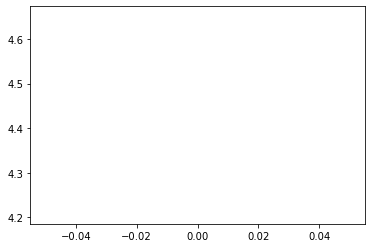

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

logger.setLevel(logging.INFO)

plt.figure()
plt.plot(loss_trend)
#plt.savefig('pictures/rnn-rnn-loss.png',dpi=400)
plt.show()

In [11]:
m = nn.LogSoftmax(dim=1)
loss = nn.NLLLoss()
# input is of size N x C = 3 x 5
input = torch.randn(3, 5, requires_grad=True)
# each element in target has to have 0 <= value < C
target = torch.tensor([1, 0, 4])
output = loss(m(input), target)

In [9]:
print(g.generate_N(p))

['marin',
 '0anda',
 ',anda',
 'lollon',
 'rinda',
 'garin',
 'nalin',
 'paran',
 'Panda',
 '2228',
 'arinda',
 'julin',
 '4anan',
 '12222',
 '4arin',
 'marin',
 'barin',
 '22222',
 '9ana',
 'xanda',
 'elondan',
 'narind',
 'paress',
 '6anda',
 'aranda',
 '7anda',
 'juna',
 'marin',
 'julin',
 'elondan',
 'sana',
 'julond',
 'oudan',
 'tarin',
 '0arin',
 'qanda',
 'lollin',
 'darin',
 'arilo',
 'yollin',
 'carin',
 'carin',
 'Aanda',
 'ianan',
 'barin',
 'Banda',
 'lollind',
 'tarin',
 'sana',
 '8anda',
 '3anda',
 'elonda',
 'juna',
 '12222',
 '0inda',
 'danda',
 'rinda',
 'Aulond',
 'handa',
 '0anda',
 'Mandan',
 '22222',
 'rinda',
 'pandes',
 'zindes',
 'harin',
 'sana',
 'karin',
 'julin',
 'barin',
 'Barin',
 'Ianda',
 'garin',
 '5anda',
 '22222',
 'alondan',
 'sana',
 '3andan',
 '12822',
 '0arin',
 'julin',
 '12222',
 'marin',
 'julilo',
 'parin',
 'carin',
 'olonda',
 '0indes',
 'arindan',
 'elondes',
 '0inda',
 'narin',
 'garin',
 '5inda',
 'sana',
 'marin',
 'carind',
 'sarin',

In [13]:
torch.cat((torch.zeros(4,1,2), torch.zeros(1,1,2)), -3)

tensor([[[0., 0.]],

        [[0., 0.]],

        [[0., 0.]],

        [[0., 0.]],

        [[0., 0.]]])

In [14]:
torch.zeros(2,1,2)

tensor([[[0., 0.]],

        [[0., 0.]]])

In [15]:
torch.exp(torch.zeros(1,2))

tensor([[1., 1.]])